In [41]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if os.path.isdir(os.path.join(PROJECT_ROOT, "src")):
    sys.path.insert(0, PROJECT_ROOT)
else:
    # fallback: try current directory
    sys.path.insert(0, os.getcwd())

import matplotlib.pyplot as plt
import copy
import numpy as np
import math


from demo_poisson import project_rhs, poisson_solver_1d, evaluate_solution
from src.basis.basis import BasisHandler
from src.matrix_generation import assemble_matrix_integral_1d
from src.primitives import Primitives_MinimalSupport
from src.operators import differentiate

In [85]:
# Benchmark initial conditions

#Exact solution case 
# f_rhs = lambda x: 1.0
# u_exact = lambda x: 0.5 * x * (1 - x)


# exact solution and its derivatives
u_exact = lambda x: np.sin(math.pi * 2 * x)
u_exact_x = lambda x: 2*math.pi * np.cos(2*math.pi * x)
f_rhs = lambda x: (4*math.pi**2) * np.sin(2*math.pi * x)

In [86]:
#Basis construction
primitives = Primitives_MinimalSupport()
basis_handler = BasisHandler(primitives=primitives, dimension=1)

In [88]:
def test(
    levels,
    u_exact=u_exact,
    u_exact_x=u_exact_x,
    f_rhs=f_rhs,
    xs_ref=np.linspace(0, 1, 400)
):
    """
    Run convergence study for the 1D Poisson wavelet–Galerkin solver.

    Parameters
    ----------
    levels : list[int]
        Refinement levels (values of J_max).
    u_exact : callable
        Exact solution u(x).
    u_exact_x : callable
        Derivative u'(x) for H1 error computation.
    f_rhs : callable
        Right-hand side f(x).
    xs_ref : np.ndarray
        Evaluation grid for error computation and plotting.

    Returns
    -------
    errors_H1 : list[float]
        H1 errors at each level.
    errors_L2 : list[float]
        L2 errors at each level.
    Ss : list[np.ndarray]
        Assembled stiffness matrices at each level.
    Ns : list[int]
        Number of basis functions per level.
    U_solutions : list[np.ndarray]
        Numerical solution values u_num(x) at xs_ref for each level.
    """
    u_ref = np.array([u_exact(x) for x in xs_ref])
    errors_L2, errors_H1, Ns, Ss, U_solutions = [], [], [], [], []
    basis_handler_diff = copy.deepcopy(basis_handler)
    for Jmax in levels:
        print(f"\n=== Testing level {Jmax} ===")

        # build fresh basis
        # primitives = Primitives_MinimalSupport()
        # basis_handler = BasisHandler(primitives=primitives, dimension=1)
        basis_handler.build_basis(J_Max=Jmax, comp_call=True, J_0=2)
        basis_handler_diff.build_basis(J_Max=Jmax, comp_call=False, J_0=2)

        # differentiated copy for stiffness
        basis_handler_diff.apply(differentiate, comp_call=True, axis=0)

        # assemble stiffness matrix and rhs
        S = assemble_matrix_integral_1d(
            basis_handler_diff.flatten(), basis_handler_diff.flatten()
        )
        Ss.append(S)

        b = project_rhs(basis_handler.flatten(), f_rhs)
        coeffs = poisson_solver_1d(S, b)

        # evaluate numerical solution and its derivative
        u_num = evaluate_solution(basis_handler.flatten(), coeffs, xs_ref)
        u_num_x = evaluate_solution(basis_handler_diff.flatten(), coeffs, xs_ref)

        # store for later analysis
        U_solutions.append(u_num)

        # compute L2 and H1 errors
        err_L2 = np.sqrt(np.trapezoid((u_num - u_ref)**2, xs_ref))
        u_ref_x = np.array([u_exact_x(x) for x in xs_ref])
        err_H1 = np.sqrt(np.trapezoid((u_num_x - u_ref_x)**2, xs_ref))

        print(f"L2 error = {err_L2:.3e},   H1 error = {err_H1:.3e}")

        errors_L2.append(err_L2)
        errors_H1.append(err_H1)
        Ns.append(len(basis_handler.flatten()))

    return errors_H1, errors_L2, Ss, Ns, U_solutions



In [89]:
levels=[2,3,4,5,6]
errors_H1, errors_L2, Ss, Ns, U_solutions=test(levels)


=== Testing level 2 ===
L2 error = 2.333e-03,   H1 error = 1.098e-01

=== Testing level 3 ===
L2 error = 2.574e-04,   H1 error = 2.602e-02

=== Testing level 4 ===
L2 error = 3.113e-05,   H1 error = 6.429e-03

=== Testing level 5 ===
L2 error = 3.858e-06,   H1 error = 1.598e-03

=== Testing level 6 ===
L2 error = 4.813e-07,   H1 error = 3.992e-04


Matrix size: 128 × 128
Original:  2702 nonzeros  (16.49% dense)
Thresholded (|S| ≥ 1e-06):  1814 nonzeros  (11.07% dense)


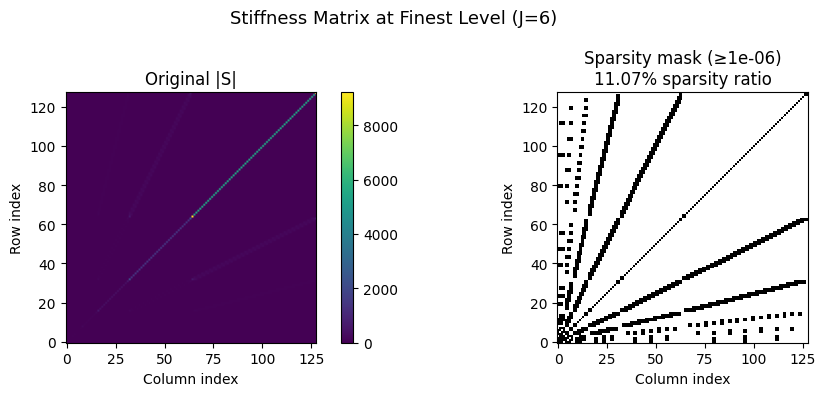

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# take the last (finest) stiffness matrix
S_last = Ss[-1]

# threshold value (tune as needed)
threshold = 1e-6

# absolute-value version and binary mask
S_abs = np.abs(S_last)
S_mask = (S_abs >= threshold).astype(float)

# compute sparsity statistics
n_total = S_last.size
n_nz_orig = np.count_nonzero(S_abs)
n_nz_mask = np.count_nonzero(S_mask)

ratio_orig = 100 * n_nz_orig / n_total
ratio_mask = 100 * n_nz_mask / n_total

print(f"Matrix size: {S_last.shape[0]} × {S_last.shape[1]}")
print(f"Original:  {n_nz_orig} nonzeros  ({ratio_orig:.2f}% dense)")
print(f"Thresholded (|S| ≥ {threshold:g}):  {n_nz_mask} nonzeros  ({ratio_mask:.2f}% dense)")

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# left: original absolute matrix
im0 = axes[0].imshow(S_abs, cmap="viridis", origin="lower")
axes[0].set_title(f"Original |S|")
axes[0].set_xlabel("Column index")
axes[0].set_ylabel("Row index")
fig.colorbar(im0, ax=axes[0], fraction=0.046)

# right: thresholded binary sparsity pattern
im1 = axes[1].imshow(S_mask, cmap="gray_r", origin="lower", interpolation="none")
axes[1].set_title(f"Sparsity mask (≥{threshold:g})\n{ratio_mask:.2f}% sparsity ratio")
axes[1].set_xlabel("Column index")
axes[1].set_ylabel("Row index")

plt.suptitle(f"Stiffness Matrix at Finest Level (J={levels[-1]})", fontsize=13)
plt.tight_layout()
plt.show()

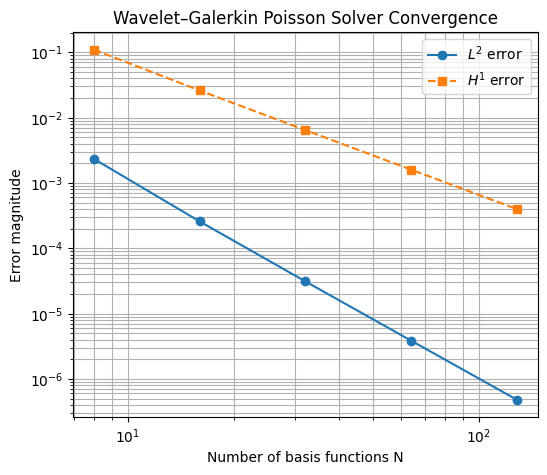

In [75]:
plt.figure(figsize=(6,5))
plt.loglog(Ns, errors_L2, 'o-', label=r'$L^2$ error')
plt.loglog(Ns, errors_H1, 's--', label=r'$H^1$ error')
plt.xlabel("Number of basis functions N")
plt.ylabel("Error magnitude")
plt.title("Wavelet–Galerkin Poisson Solver Convergence")
plt.grid(True, which="both")
plt.legend()
plt.show()